# Kafka broker
**Apache Kafka** - самая распространенная в мире система, на основе которой строятся приложения для поточной обработки данных. Она имеет несколько преимуществ:
- высокая пропускная способность
- высокая доступность за счет распределенной архитектуры и репликации
- у каждого сообщения есть свой номер, который называется offset, что позволяет гранулярно сохранять состояние стрима

## Архитектура системы

#### Topic
Топик - это "таблицы" в Kafka. Мы пишем данные в топик и читаем данные из топика. Топик как правило распределен по нескольким узлам кластера для обеспечения высокой доступности и скорости работы с данными

<img align="center" width="500" height="500" src="https://kafka.apache.org/25/images/log_anatomy.png">

#### Partition
Партиции - это блоки, из которых состоят топики. Партиция представляет собой неделимый блок, который хранится на одном из узлов. Топик может иметь произвольное количество партиций. Чем больше партиций - тем выше параллелзим при чтении и записи, однако слишком большое число партиций в топике может привести к замедлению работы всей системы.

#### Replica
Каждая партиция имеет (может иметь) несколько реплик. Внешние приложения всегда работают (читают и пишут) с основной репликой. Остальные реплики являются дочерними и не используются во внешнем IO. Если узел, на котором расположена основная реплика, падает, то одна из дочерних реплик становится основной и работа с данными продолжается

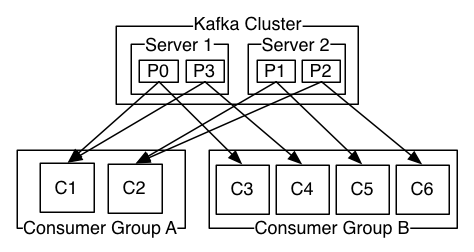

#### Message
Сообщения - это данные, которые мы пишем и читаем в Kafka. Они представлены кортежем (Key, Value), но ключ может быть иметь значение `null` (используется не всегда). Сереализация и десереализация данных всегда происходит на уровне клиентов Kafka. Сама Kafka ничего о типах данных не знает и хранит ключи и значения в виде массива байт

#### Offset
Оффсет - это порядковый номер сообщения в партиции. Когда мы пишем сообщение (сообщение всегда пишется в одну из партиций топика), Kafka помещает его в топик с номер `n+1`, где `n` - номер последнего сообщения в этом топике

<img align="center" width="400" height="400" src="https://kafka.apache.org/25/images/log_consumer.png">

#### Producer
Producer - это приложение, которое пишет в топик. Producer'ов может быть много. Параллельная запись достигается за счет того, что каждое новое сообщение попадает в случайную партицию топика (если не указан `key`)

#### Consumer
Consumer - это приложение, читающее данные из топика. Consumer'ов может быть много, в этом случае они называются `consumer group`. Параллельное чтение достигается за счет распределения партиций топика между consumer'ами в рамках одной группы. Каждый consumer читает данные из "своих" партиций и ничего про другие не знает. Если consumer падает, то "его" партиции переходят другим consumer'ам.

#### Commit
Коммитом в Kafka называют сохранение информации о факте обработки сообщения с определенным оффсетом. Поскольку оффсеты для каждой партиции топика свои, то и информация о последнем обработанном оффсете хранится по каждой партиции отдельно. Обычные приложения пишут коммиты в специальный топик Kafka, который имеет название `__consumer_offsets`. Spark хранит обработанные оффсеты по каждому батчу в ФС (например, в HDFS).

#### Retention
Поскольку кластер Kafka не может хранить данные вечно, то в ее конфигурации задаются пороговые значение по **объему** и **времени хранения** для каждого топика, при превышении которых данные удаляются. Например, если у топика A установлен renention по времени 1 месяц, то данные будут хранится в системе не менее одного месяца (и затем будут удалены одной из внутренних подсистем)
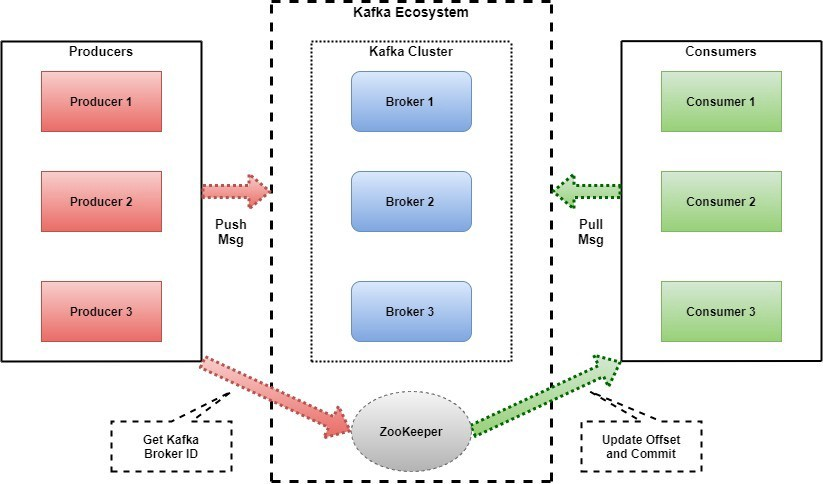

## Запуск kafka в docker
https://docs.confluent.io/platform/current/quickstart/ce-docker-quickstart.html#cp-quickstart-step-1

```shell
docker run -d \
    --net=host \
    --name=zookeeper \
    -e ZOOKEEPER_CLIENT_PORT=32181 \
    confluentinc/cp-zookeeper:3.1.1
```

```shell
docker run -d \
    --net=host \
    --name=kafka \
    -e KAFKA_ZOOKEEPER_CONNECT=localhost:32181 \
    -e KAFKA_ADVERTISED_LISTENERS=PLAINTEXT://localhost:29092 \
    confluentinc/cp-kafka:3.1.1
```

## Запуск kafka локально
https://kafka.apache.org/quickstart

```shell
wget https://archive.apache.org/dist/kafka/2.7.0/kafka_2.13-2.7.0.tgz
tar -xzf kafka_2.13-2.7.0.tgz

# Start the ZooKeeper service
bin/zookeeper-server-start.sh config/zookeeper.properties

# Start the Kafka broker service
bin/kafka-server-start.sh config/server.properties
```

In [2]:
!kafka_2.13-2.7.0/bin/kafka-topics.sh --create --topic students-test --bootstrap-server localhost:9092

Created topic students_test.


In [ ]:
# Создадим топик
!kafka_2.13-2.7.0/bin/kafka-topics.sh --create --topic students --bootstrap-server localhost:9092
# Редактируем топик
!kafka_2.13-2.7.0/bin/kafka-configs.sh --bootstrap-server localhost:9092 --entity-type topics --entity-name students --alter --add-config retention.ms=60000
# Отправляем данные
!kafka_2.13-2.7.0/bin/kafka-console-producer.sh --topic students --bootstrap-server localhost:9092

In [2]:
from kafka import KafkaProducer, KafkaConsumer

producer = KafkaProducer(bootstrap_servers='localhost:9092')

In [3]:
producer.send('students', b'Aleksandr')

In [13]:
consumer = KafkaConsumer(
    'students',
     bootstrap_servers=['localhost:9092'],
     auto_offset_reset='earliest',
     enable_auto_commit=True,
#      group_id='my-group',
)

In [ ]:
for message in consumer:
    print(message.value)

b'Aleksandr'
